In [1]:
#import package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

#from fairness import unfairness
#from fairness import WassersteinNoBin

In [2]:
#%load_ext autoreload
#%autoreload 2
from fairness.wassersteinssanobin import WassersteinNoBin
from fairness.metrics import unfairness

In [12]:
size = 10000

age = np.random.randint(18, 66, size)

gender = np.random.choice(['m', 'w', 'nb'], size)

# Générer les salaires en fonction du genre en suivant les lois gamma spécifiées
salaries = []
for g in gender:
    if g == 'm':
        salary = np.random.gamma(20, 0.5)
    elif g == 'w':
        salary = np.random.gamma(2, 2)
    else:
        salary = np.random.gamma(0.5, 6)
    salaries.append(salary)

# Créer le DataFrame
df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Income': salaries
})

In [13]:
x_ssa = df['Gender'].to_numpy()
y_ssa = df['Income'].to_numpy()
x_ssa_calib, x_ssa_test, y_calib, y_test = train_test_split(x_ssa,y_ssa, test_size=0.3)

In [14]:
df_test = pd.DataFrame()
df_test['Gender'] = x_ssa_test
df_test['Income'] = y_test
display(df_test)

,Gender,Income
0,m,13.046596
1,nb,0.134104
2,w,3.015963
3,m,10.057629
4,w,1.527067
...,...,...
2995,m,12.822788
2996,m,10.726808
2997,nb,1.491012
2998,m,8.218461


<Axes: xlabel='Income', ylabel='Density'>

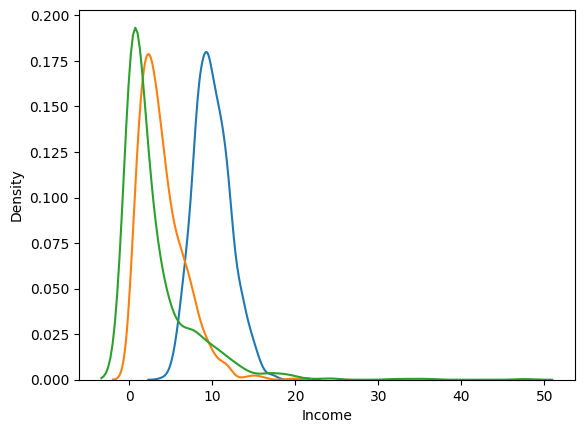

In [15]:
sns.kdeplot(df_test[df_test.Gender=='m'], x = df_test[df_test.Gender=='m']['Income'])
sns.kdeplot(df_test[df_test.Gender=='w'], x = df_test[df_test.Gender=='w']['Income'])
sns.kdeplot(df_test[df_test.Gender=='w'], x = df_test[df_test.Gender=='nb']['Income'])

In [16]:
x = WassersteinNoBin()
x.fit(y_calib, x_ssa_calib)
y_fair = x.transform(y_test,x_ssa_test)

In [17]:
df_fair = pd.DataFrame()
df_fair['Gender'] = x_ssa_test
df_fair['Income'] = y_fair
display(df_fair)

,Gender,Income
0,m,9.789956
1,nb,3.101054
2,w,4.390499
3,m,5.030203
4,w,3.184367
...,...,...
2995,m,9.496172
2996,m,5.828747
2997,nb,5.021087
2998,m,3.367188


<Axes: xlabel='Income', ylabel='Density'>

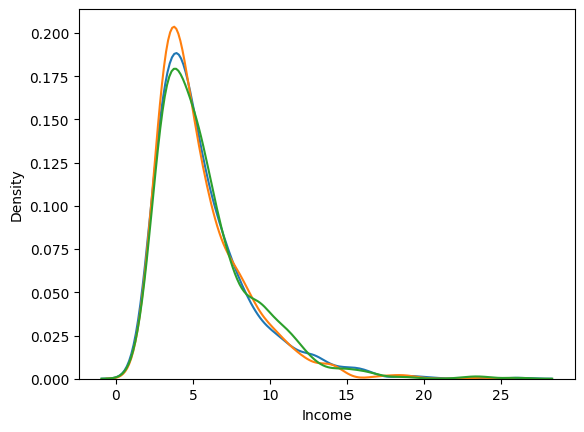

In [18]:
sns.kdeplot(df_fair[df_fair.Gender=='m'], x = df_fair[df_fair.Gender=='m']['Income'])
sns.kdeplot(df_fair[df_fair.Gender=='w'], x = df_fair[df_fair.Gender=='w']['Income'])
sns.kdeplot(df_fair[df_fair.Gender=='nb'], x = df_fair[df_fair.Gender=='nb']['Income'])

In [19]:
unfairness(y_fair, x_ssa_test)

([0.5226571630708197, 2.3108876915156813, 0.5416140808498504],
 2.3108876915156813)

In [20]:
unfairness(y_test, x_ssa_test)

([5.375792651871185, 27.787986617288492, 26.29215995834668],
 27.787986617288492)